In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from grouper import group_by_volume, group_by_time
from pyfolio.timeseries import perf_stats
from functools import partial
from utils import chart_price, plot, v_backtester, c_backtester, perf, perf_var
import sys
sys.path.append('/home/tomek/ib_tools')
from indicators import get_ATR, get_signals
import matplotlib.pyplot as plt
from typing import NamedTuple
from collections import namedtuple
%matplotlib inline

In [2]:
from datastore_pytables import Store

In [3]:
store = Store()
store.keys()

['/cont/min/CL_20191120_NYMEX_USD',
 '/cont/min/ES_20191220_GLOBEX_USD',
 '/cont/min/GC_20191227_NYMEX_USD',
 '/cont/min/GE_20191216_GLOBEX_USD',
 '/cont/min/NKD_20191212_GLOBEX_USD',
 '/cont/min/NQ_20191220_GLOBEX_USD',
 '/cont/min/YM_20191220_ECBOT_USD',
 '/cont/min/ZB_20191219_ECBOT_USD',
 '/cont/min/ZF_20191231_ECBOT_USD',
 '/cont/min/ZN_20191219_ECBOT_USD']

In [4]:
multiplier = 20
#periods = 20
periods = [5, 10, 20, 40, 80, 160] 
ema_fast = 5
ema_slow = 120 # number of periods for moving average filter
#sl_atr = 1 # stop loss in ATRs
atr_periods = 180 # number of periods to calculate ATR on
time_int = 23 # interval in minutes to be used to define volume candle
commission = 2.1 # level of commision per transaction in dollars
bankroll = 15000

In [5]:
contract = store.read('/cont/min/GC_20191227_NYMEX_USD').sort_index()
#contract = pd.read_pickle('data/minute_GC_cont_non_active_included.pickle')
contract = contract.loc['20180101': '20181231']

In [6]:
#avg_vol = contract.loc['20190621':].volume.rolling(time_int).sum().mean()
avg_vol = contract.volume.rolling(time_int).sum().mean()
avg_vol

4135.432031693412

In [7]:
vol_candles = group_by_volume(contract, avg_vol)
"""
vol_candles = contract.resample('30min').agg({'open': 'first',
                                           'high': 'max',
                                           'low': 'min',
                                           'close': 'last',
                                           'volume': 'sum',
                                           'barCount': 'sum'}).reset_index().dropna()
"""
vol_candles['atr'] = get_ATR(vol_candles, atr_periods)
vol_candles

,date,open,high,low,close,barCount,volume,atr
label,,,,,,,,
0,2018-01-02 00:35:00,1305.3,1309.7,1304.6,1308.8,1554,4051,5.100000
1,2018-01-02 01:38:00,1308.9,1309.3,1307.3,1308.1,1625,4167,3.541389
2,2018-01-02 02:02:00,1308.1,1309.3,1306.4,1306.5,1779,4053,3.325213
3,2018-01-02 02:41:00,1306.5,1309.0,1306.2,1308.9,1893,4449,3.191713
4,2018-01-02 03:45:00,1308.9,1309.0,1307.8,1308.1,1697,4238,2.784470
...,...,...,...,...,...,...,...,...
14345,2018-12-31 19:10:00,1283.5,1284.0,1282.6,1283.8,1800,4240,1.893279
14346,2018-12-31 19:28:00,1283.9,1284.3,1281.9,1282.1,1148,2994,1.898878
14347,2018-12-31 20:29:00,1282.0,1283.3,1280.2,1283.3,2281,6048,1.912150


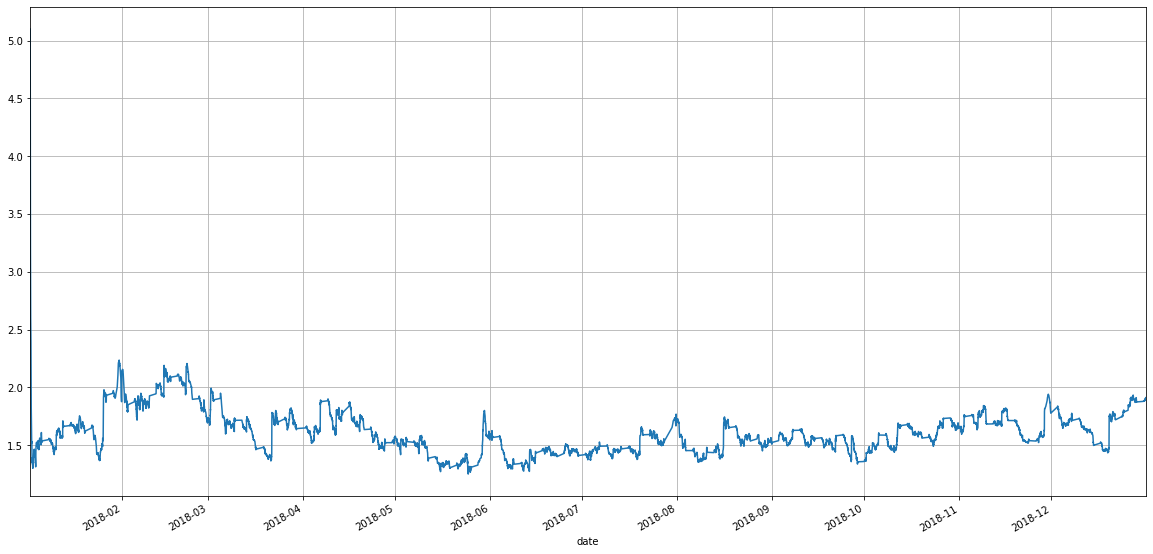

In [8]:
chart = vol_candles.set_index('date')
chart.atr.plot(figsize=(20,10), grid=True);

In [9]:
vol_candles.atr.mean(), vol_candles.atr.median()

(1.597702598920708, 1.5679783254444102)

In [10]:
#vol_candles['atr'] = 20

In [11]:
data = vol_candles.copy()
data['ema_fast'] = data.close.ewm(span=ema_fast).mean()
data['ema_slow'] = data.close.ewm(span=ema_slow).mean()
#data['min'] = data.close.rolling(periods).min()
#data['max'] = data.close.rolling(periods).max()
rows_to_drop = max(*periods, ema_slow)
#rows_to_drop = max(periods, ema_fast)
data = data.iloc[rows_to_drop:]
data.reset_index(drop=True, inplace=True)

In [12]:
#data['buy_signal'] = (data.close >= data['max']) * 1
#data['sell_signal'] = (data.close <= data['min']) * -1
#data['signal'] = data.buy_signal + data.sell_signal
#del data['buy_signal']
#del data['sell_signal']
data['signal'] = get_signals(data.close, periods)
data['filter'] = np.sign(data['ema_fast'] - data['ema_slow'])
data['filtered_signal'] = data['signal'] * ((data['signal'] * data['filter']) == 1)
#data['filtered_signal'] = data['signal']

In [13]:
data.rename(columns={'open': 'price'}, inplace=True)

In [14]:
b = c_backtester(data, sl_atr=2, trailing_sl=True, active_close=True, block_stop=False, take_profit=0)
#results_c = perf(b, multiplier, bankroll) 

Annual return                 0.0844584
Cumulative returns            0.0869036
Annual volatility             0.0614144
Sharpe ratio                    1.35093
Calmar ratio                    3.50179
Stability                      0.908251
Max drawdown                 -0.0241186
Omega ratio                     1.27182
Sortino ratio                   2.47299
Skew                            1.07361
Kurtosis                        1.80831
Tail ratio                      1.58237
Daily value at risk         -0.00740826
Win percent                    0.397143
Average gain                    4.49928
Average loss                   -2.42275
Avg gain/loss ratio              1.8571
Position EV                    0.326286
Positions per day               1.35135
Days per position                  0.74
Actual avg. duration    0 days 10:37:00
Days                                259
Positions                           350
Trades                              700
Monthly EV                      9.25946


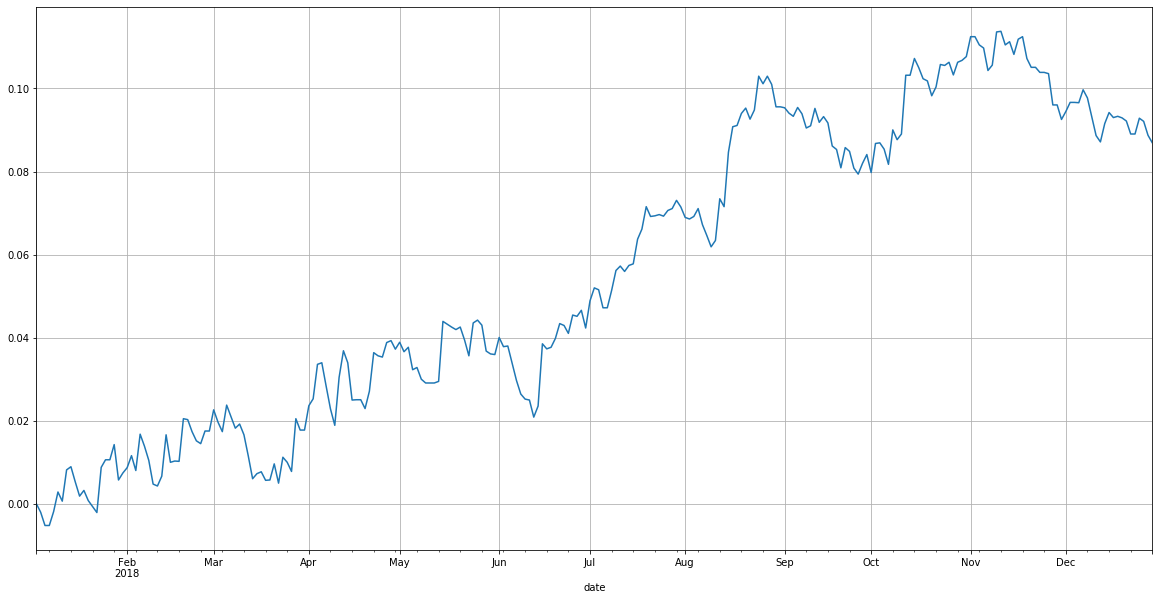

In [15]:
results = perf(b) 

In [16]:
prices = data.set_index('date').close.resample('B').last()
returns = prices.pct_change().fillna(0)
vols_returns = returns.ewm(span=5).std()
vols_prices = vols_returns * prices

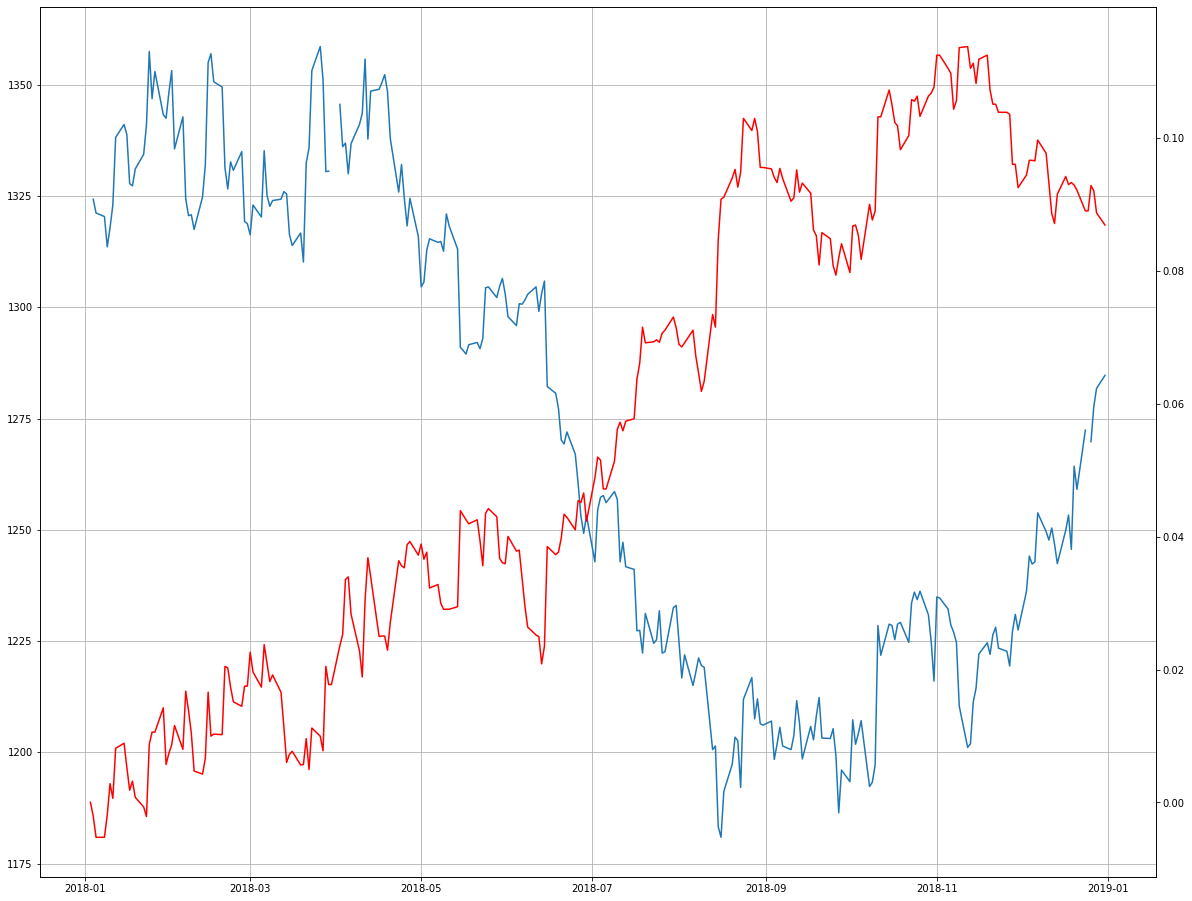

In [17]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20, 16))
ax = fig.add_subplot(111)
ax.plot(prices)
ax1 = ax.twinx()
ax1.plot(results.daily.path, color='red')
ax.grid()
plt.show();

In [18]:
monthly = pd.DataFrame({'open': results.daily.balance.resample('M').first(),
                        'close': results.daily.balance.resample('M').last()})
monthly['c'] = monthly['close'].shift().fillna(monthly['open'].iloc[0])
monthly['pnl'] = monthly['close'] - monthly['c']
del monthly['open']
monthly.columns = ['close', 'open', 'pnl']
monthly

,close,open,pnl
date,,,
2018-01-31,1323.8,1314.1,9.7
2018-02-28,1337.1,1323.8,13.3
2018-03-31,1337.4,1337.1,0.3
2018-04-30,1363.0,1337.4,25.6
2018-05-31,1361.3,1363.0,-1.7
2018-06-30,1369.7,1361.3,8.4
2018-07-31,1408.0,1369.7,38.3
2018-08-31,1439.7,1408.0,31.7
2018-09-30,1424.6,1439.7,-15.1


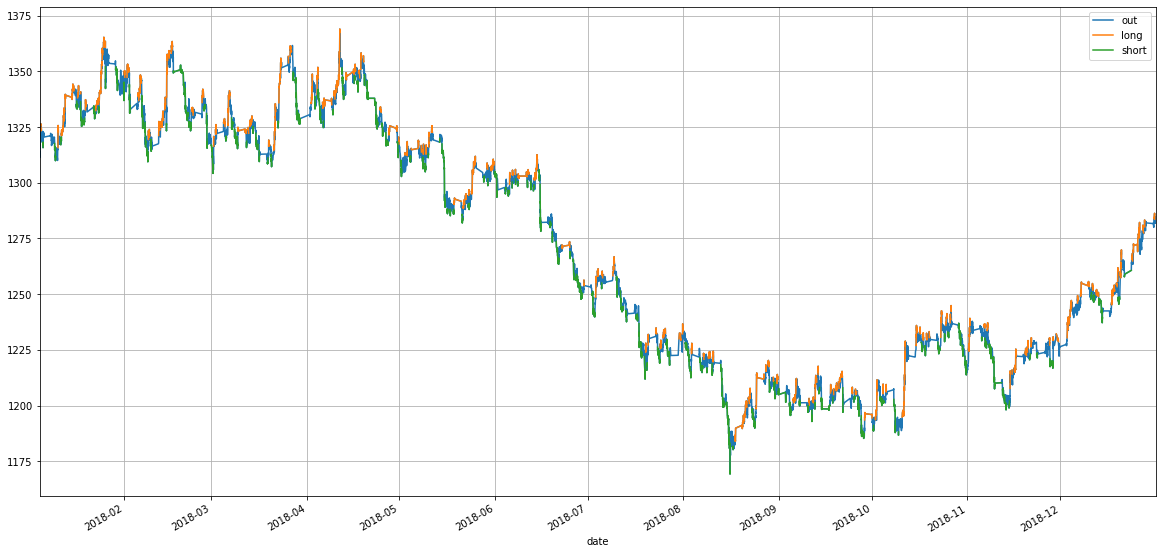

In [19]:
a = chart_price(b['price'], b['position'])

In [20]:
results.positions.sort_values('pnl')

,date_o,open,date_c,close,reason,pnl,duration
25,2018-01-30 15:12:00,-1339.3,2018-01-30 18:41:00,1350.5,stop-out,-11.2,0 days 03:29:00
43,2018-02-14 14:37:00,-1323.4,2018-02-14 15:03:00,1330.5,stop-out,-7.1,0 days 00:26:00
344,2018-12-21 19:21:00,-1258.0,2018-12-24 02:33:00,1264.2,stop-out,-6.2,2 days 07:12:00
154,2018-05-29 15:24:00,-1299.4,2018-05-29 16:57:00,1304.7,stop-out,-5.3,0 days 01:33:00
38,2018-02-09 01:37:00,1323.9,2018-02-09 03:42:00,-1319.1,stop-out,-4.8,0 days 02:05:00
...,...,...,...,...,...,...,...
44,2018-02-14 16:06:00,1338.5,2018-02-15 00:46:00,-1353.0,stop-out,14.5,0 days 08:40:00
280,2018-10-10 20:42:00,1194.9,2018-10-11 15:31:00,-1209.4,stop-out,14.5,0 days 18:49:00
116,2018-04-20 10:01:00,-1343.4,2018-04-24 03:09:00,1327.7,stop-out,15.7,3 days 17:08:00
173,2018-06-15 14:24:00,-1299.3,2018-06-15 20:11:00,1281.1,stop-out,18.2,0 days 05:47:00


In [21]:
#results.daily.to_pickle('GC_30_2019.pickle')

In [22]:
results.positions[results.positions['reason'] != 'stop-out']

,date_o,open,date_c,close,reason,pnl,duration
